<a href="https://colab.research.google.com/github/KaraNoSora/SE207_WI22_Course_Materials/blob/main/Project/SE_207_Final_Project_Finalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 2**

You are given another dataset containing 3000 RVE images and their overall properties. Each image still has two materials. However, $E_0, \nu_0, E_1, \nu_1$ are now variables, so we have to train a new model to predict the homogenized material properties with both the RVE image and four components' properties given as input. 

The distribution of materials in an RVE image and the components' properties are independent of each other. Therefore, a reasonable way to start this problem is to feed an RVE image to convolutional layers first. After obtaining the flattened feature maps, we can input the feature maps and material properties together into the fully connected layers and get the final output.

1. Modify the archtecture in Part 1 to solve this problem.

In [1]:
#@title import libraries
import time
import torch
import torch.nn as nn
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import shutil
import matplotlib as ml
from sklearn.metrics import mean_absolute_percentage_error
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from joblib import dump, load
from sklearn.metrics import mean_squared_error
global device, print_freq
device = torch.device('cuda')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

ml.rc('font', **font)
plt.rc('text', usetex=True)
from numpy import genfromtxt

## Data augmentation by flipping and rotating

In [2]:
# ####################### Original dataset ###########################

imgs         = np.load('rve_image_p2.npy')
properties   = np.load('overall_property_p2.npy')
materials   = np.load('rve_material_p2.npy')

properties.astype(np.float32)
imgs.astype(np.float32)
materials.astype(np.float32)

imgs_rot    = np.rot90(imgs, 1, (1, 2))
imgs_trans  = np.flip(imgs, (1))
imgs_aug    = np.concatenate((imgs, imgs_rot, imgs_trans), axis=0)
imgs_aug    = np.reshape(imgs_aug, (9000, 1, 128, 128))

properties_aug              = np.zeros((9000,2))
properties_aug[0:3000,:]    = properties
properties_aug[3000:6000,:] = properties
properties_aug[6000:9000,:] = properties

materials_aug              = np.zeros((9000,4))
materials_aug[0:3000,:]    = materials
materials_aug[3000:6000,:] = materials
materials_aug[6000:9000,:] = materials

rng            = np.random.default_rng()
numbers        = rng.choice(9000, size=9000, replace=False)
imgs_aug       = imgs_aug[numbers].copy()
properties_aug = properties_aug[numbers,0:2].copy()
materials_aug  = materials_aug[numbers,0:4].copy()

imgs_aug = np.reshape(imgs_aug, (9000, 1, 128, 128))
imgs_tensor = torch.from_numpy(imgs_aug)

E_transform  = MinMaxScaler()
nu_transform = MinMaxScaler()
original_E   = properties_aug[:,0:1].copy()
original_nu  = properties_aug[:,1:2].copy()
E  = E_transform.fit_transform(properties_aug[:,0:1])
nu = nu_transform.fit_transform(properties_aug[:,1:2])
properties_tensor = torch.zeros(9000, 2)
properties_tensor[:,:] = torch.from_numpy(np.hstack((E, nu)))

E1_transform  = MinMaxScaler()
nu1_transform = MinMaxScaler()
E2_transform  = MinMaxScaler()
nu2_transform = MinMaxScaler()
original_E1   = materials_aug[:,0:1].copy()
original_nu1  = materials_aug[:,1:2].copy()
original_E2   = materials_aug[:,2:3].copy()
original_nu2  = materials_aug[:,3:4].copy()

E1  = E1_transform.fit_transform(materials_aug[:,0:1])
nu1 = nu1_transform.fit_transform(materials_aug[:,1:2])
E2  = E2_transform.fit_transform(materials_aug[:,2:3])
nu2 = nu2_transform.fit_transform(materials_aug[:,3:4])

materials_tensor = torch.zeros(9000, 4)
materials_tensor[:,:] = torch.from_numpy(np.hstack((E1, nu1, E2, nu2)))

In [3]:
# ####################### Original dataset ###########################

# imgs         = np.load('rve_image_p2.npy')
# properties   = np.load('overall_property_p2.npy')
# materials   = np.load('rve_material_p2.npy')

# properties.astype(np.float32)
# imgs.astype(np.float32)
# materials.astype(np.float32)

# rng        = np.random.default_rng()
# numbers    = rng.choice(3000, size=3000, replace=False)
# imgs       = imgs[numbers].copy()
# properties = properties[numbers,0:2].copy()
# materials  = materials[numbers,0:4].copy()

# imgs = np.reshape(imgs, (3000, 1, 128, 128))
# imgs_tensor = torch.from_numpy(imgs)

# E_transform  = MinMaxScaler()
# nu_transform = MinMaxScaler()
# original_E   = properties[:,0:1].copy()
# original_nu  = properties[:,1:2].copy()
# E  = E_transform.fit_transform(properties[:,0:1])
# nu = nu_transform.fit_transform(properties[:,1:2])
# properties_tensor = torch.zeros(3000, 2)
# properties_tensor[:,:] = torch.from_numpy(np.hstack((E, nu)))

# E1_transform  = MinMaxScaler()
# nu1_transform = MinMaxScaler()
# E2_transform  = MinMaxScaler()
# nu2_transform = MinMaxScaler()
# original_E1   = materials[:,0:1].copy()
# original_nu1  = materials[:,1:2].copy()
# original_E2   = materials[:,2:3].copy()
# original_nu2  = materials[:,3:4].copy()

# E1  = E1_transform.fit_transform(materials[:,0:1])
# nu1 = nu1_transform.fit_transform(materials[:,1:2])
# E2  = E2_transform.fit_transform(materials[:,2:3])
# nu2 = nu2_transform.fit_transform(materials[:,3:4])

# materials_tensor = torch.zeros(3000, 4)
# materials_tensor[:,:] = torch.from_numpy(np.hstack((E1, nu1, E2, nu2)))

In [4]:
#@title Auxiliary class: Data set
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, inp, mat, out):
        self.inp = inp
        self.out = out
        self.mat = mat

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, index):
        return self.inp[index], self.mat[index], self.out[index]

class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
#@title train_step(), test_step()
def train_step(train_loader, model, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    losses     = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, mat, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input  = input.to(device)
        target = target.to(device)
        mat    = mat.to(device)

        # compute output
        output = model(input, mat)
        loss = criterion(output, target)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 10 == 0:

            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))
    return losses.avg

def test_step(val_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, mat, target) in enumerate(val_loader):

        input  = input.to(device)
        target = target.to(device)
        mat    = mat.to(device)

        # compute output
        output = model(input, mat)
        loss = criterion(output, target)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 10 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(val_loader), batch_time=batch_time, loss=losses))

    return losses.avg

In [6]:
#@title train_NN()

# early stoping: save the model with the lowest test loss
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def train_NN(model, net_info, train_loader, test_loader):
    epochs = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses = np.empty([epochs, 1])

    min_loss = 1e4

    # In this case, we should use the binary cross-entropy as the loss function
    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'])

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 50:
            if epoch % 50 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

        # train for one epoch
        train_losses_temp = train_step(train_loader, model, lossfun, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp

        # evaluate on test set
        test_losses_temp = test_step(test_loader, model, lossfun, epoch)
        test_losses[epoch] = test_losses_temp

        # remember the best test set performance and save checkpoint
        is_best = test_losses[epoch] > min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('val_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    
    # plot training/test loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi = 600)
    ax[0].plot(train_losses)
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('MSE')
    ax[0].title.set_text('Training loss')
    ax[0].set_yscale('log')
    ax[0].set_ylim([10**-4, 10**-1])
    ax[0].grid('on')

    ax[1].plot(test_losses)
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('MSE')
    ax[1].title.set_text('Validation loss')
    ax[1].set_yscale('log')
    ax[1].grid('on')
    ax[1].set_ylim([10**-4, 10**-1])
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"    
    return model

In [7]:
#@title CNN Architecture
class rveCNN(torch.nn.Module):

    def __init__(self):

        super().__init__()

        # a 8 x 1 x 5 x 5 filter
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0)
        # a 16 x 8 x 5 x 5 filter
        self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0)
       
        self.avgpool1 = torch.nn.AvgPool2d(kernel_size=3, stride=3)
        self.avgpool2 = torch.nn.AvgPool2d(kernel_size=6, stride=6)
        self.relu = torch.nn.ReLU()

        self.fc1 = torch.nn.Linear(in_features=580, out_features=128)
        self.fc2 = torch.nn.Linear(in_features=128, out_features=2)
        #self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x, mat_prop):
        
        # convert x to the dtype 'torch.float32'
        out = self.conv1(x.float())
        out = self.relu(out)
        out = self.avgpool1(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.avgpool2(out)
        #print(out.shape)    
        out = torch.cat((out.reshape(out.size(0), -1), mat_prop), 1)
        out = self.fc1(out)
        out = self.relu(out)
        #out = self.dropout(out)
        out = self.fc2(out)
        # probability P('crack'|x)
        out = self.relu(out)
        return out

In [8]:
trainer_info = {'epochs': 300, 
                'train_size':  7000,
                'train_batch': 100,
                'test_batch':  200,
                #'weight_decay': 1e-4
                'lr0': 1e-3,
                'lr_decay': 0.2}

note = 'rve_part1_test'
print_freq = 300

model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(trainer_info['epochs']) + 'ep_' + note
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('model name: ' + model_name)
print(device)

model name: model_7000train_300ep_rve_part1_test
cuda


In [9]:
#@title main_program
def main_program(inp, mat, out, trainer_info, model_name):

    num_sample = trainer_info['train_size']
    inp_train = inp[0:num_sample, :, :, :]
    mat_train = mat[0:num_sample,:]
    out_train = out[0:num_sample,:]
    training_set = MyDataset(inp_train, mat_train, out_train)

    inp_test = inp[num_sample:8000, :, :, :]
    mat_test = mat[num_sample:8000,:]
    out_test = out[num_sample:8000,:]
    test_set = MyDataset(inp_test, mat_test, out_test)

    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set, 
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                              batch_size=trainer_info['test_batch'], 
                                              shuffle=True)

    # train the model
    model = rveCNN().to(device)
    print(model_name)
    print(model)
    
    model = train_NN(model, trainer_info, train_loader, test_loader)
    torch.save(model.state_dict(), model_name)

    return model

model_7000train_300ep_rve_part1_test
rveCNN(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool1): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (avgpool2): AvgPool2d(kernel_size=6, stride=6, padding=0)
  (relu): ReLU()
  (fc1): Linear(in_features=580, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Epoch: [0/300][0/70]	LR: 0.001	Time 0.079 (0.079)	Data 0.012 (0.012)	Loss 0.1867862 (0.186786)	
Test: [0/5]	Time 0.014 (0.014)	Loss 0.0538247 (0.0538)	
Epoch: [10/300][0/70]	LR: 0.001	Time 0.007 (0.007)	Data 0.002 (0.002)	Loss 0.0307731 (0.030773)	
Test: [0/5]	Time 0.009 (0.009)	Loss 0.0331549 (0.0332)	
Epoch: [20/300][0/70]	LR: 0.001	Time 0.010 (0.010)	Data 0.003 (0.003)	Loss 0.0398097 (0.039810)	
Test: [0/5]	Time 0.009 (0.009)	Loss 0.0409918 (0.0410)	
Epoch: [30/300][0/70]	LR: 0.001	Time 0.008 (0.008)	Data 0.002 (0.002)	Loss 0.0241657 (0.024166)	
Test: [0/5]	Time 0.0

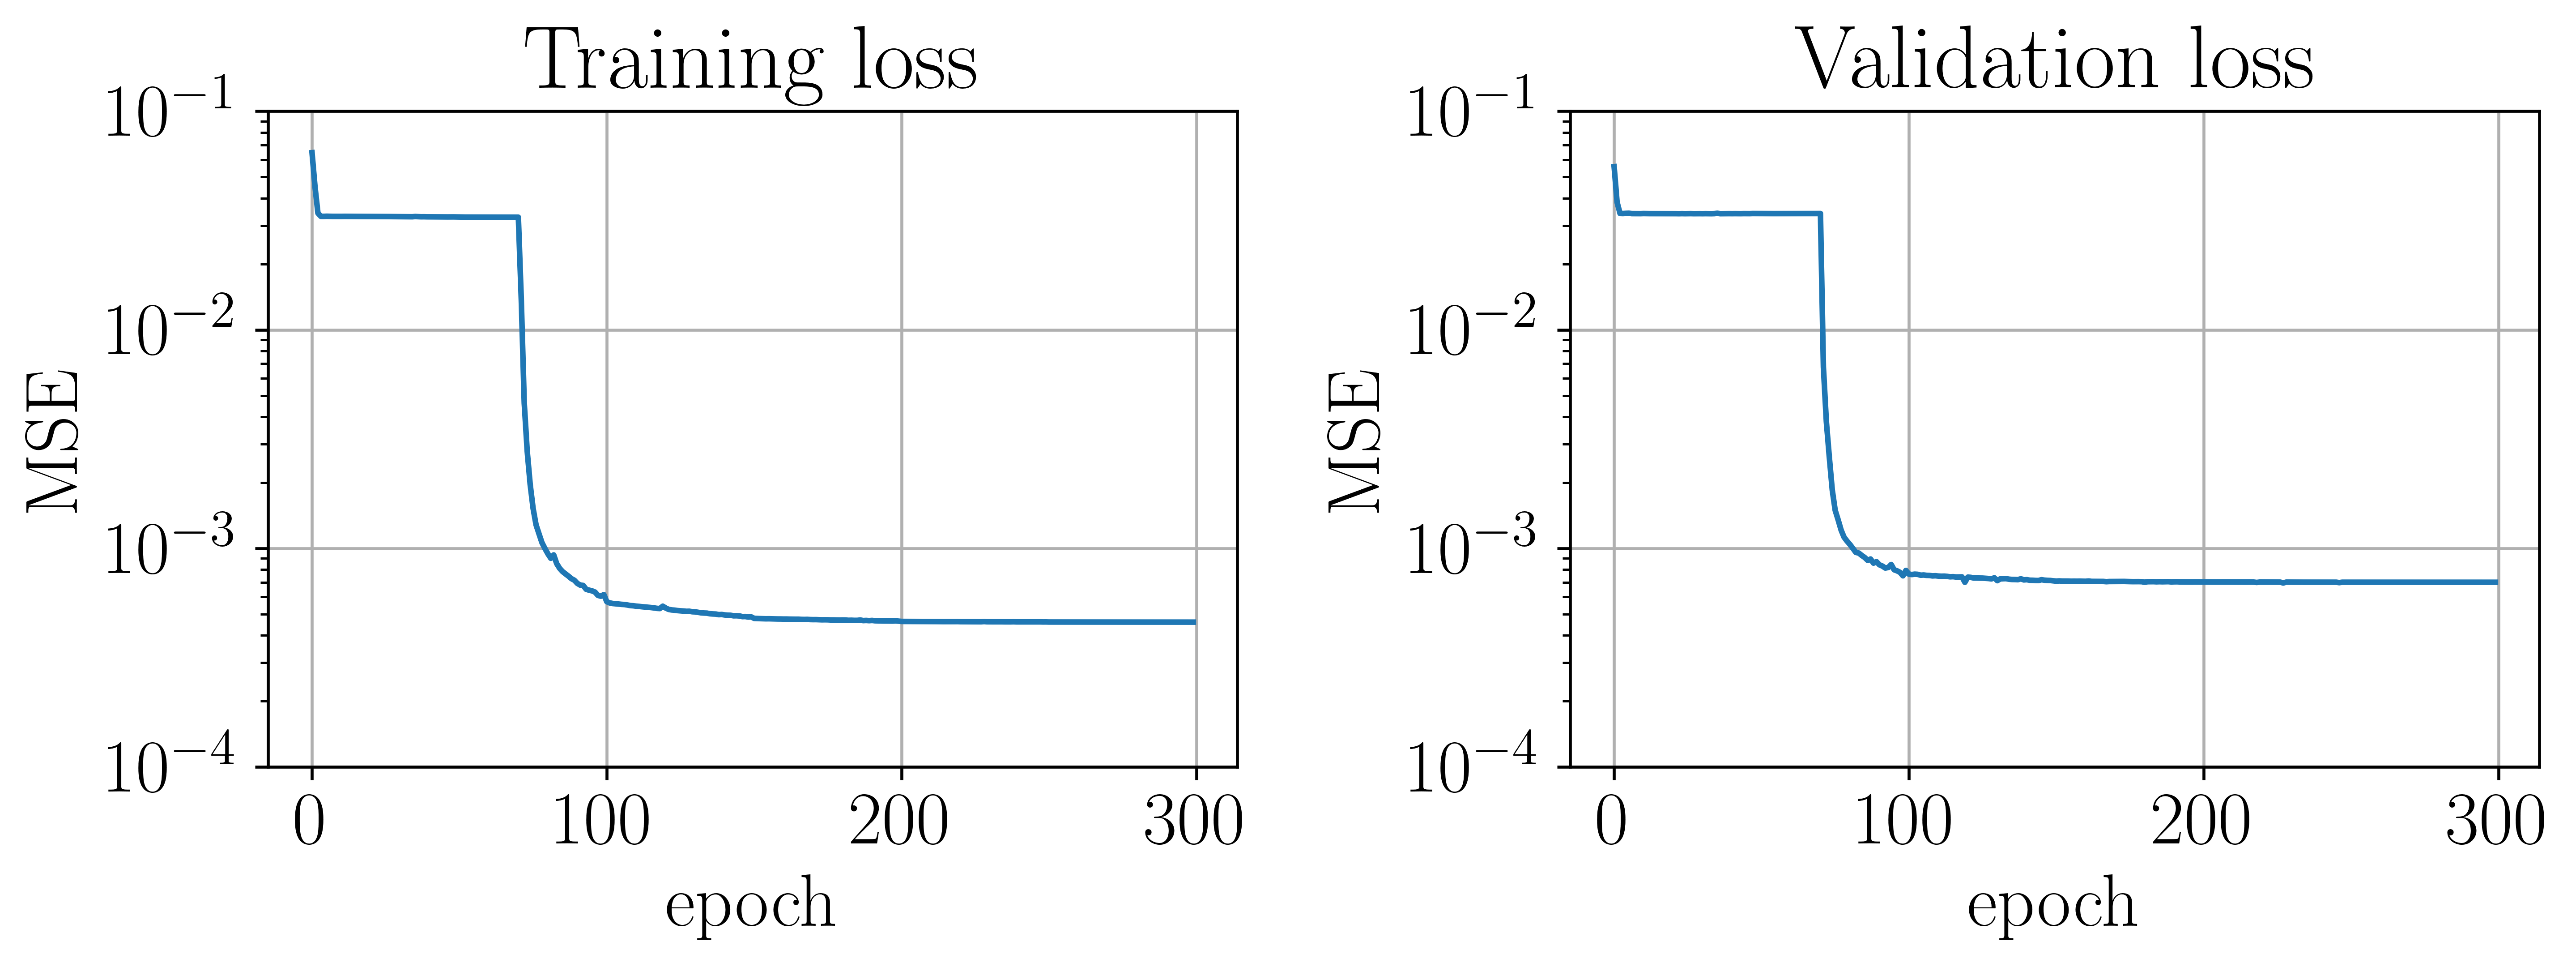

In [10]:
print_freq = 100
device = torch.device('cuda')
np.shape(materials_tensor)
model = main_program(imgs_tensor, materials_tensor, properties_tensor, trainer_info, model_name)

In [11]:
nstart = 8000
nend = 9000

yhat = model(imgs_tensor[nstart:nend,:,:,:].to(device), materials_tensor[nstart:nend,:].to(device))
yhat_numpy = yhat.detach().cpu().numpy()
mean_squared_error(yhat_numpy[:,1:2], nu[nstart:nend,0:1])
print(mean_squared_error(yhat_numpy[:,0:1], E[nstart:nend,0:1]))
print(mean_squared_error(yhat_numpy[:,1:2], nu[nstart:nend,0:1]))
print(mean_squared_error(yhat_numpy, np.hstack((E[nstart:nend], nu[nstart:nend]))))

0.00046131153782068144
0.0008672818758230303
0.0006642967068218554


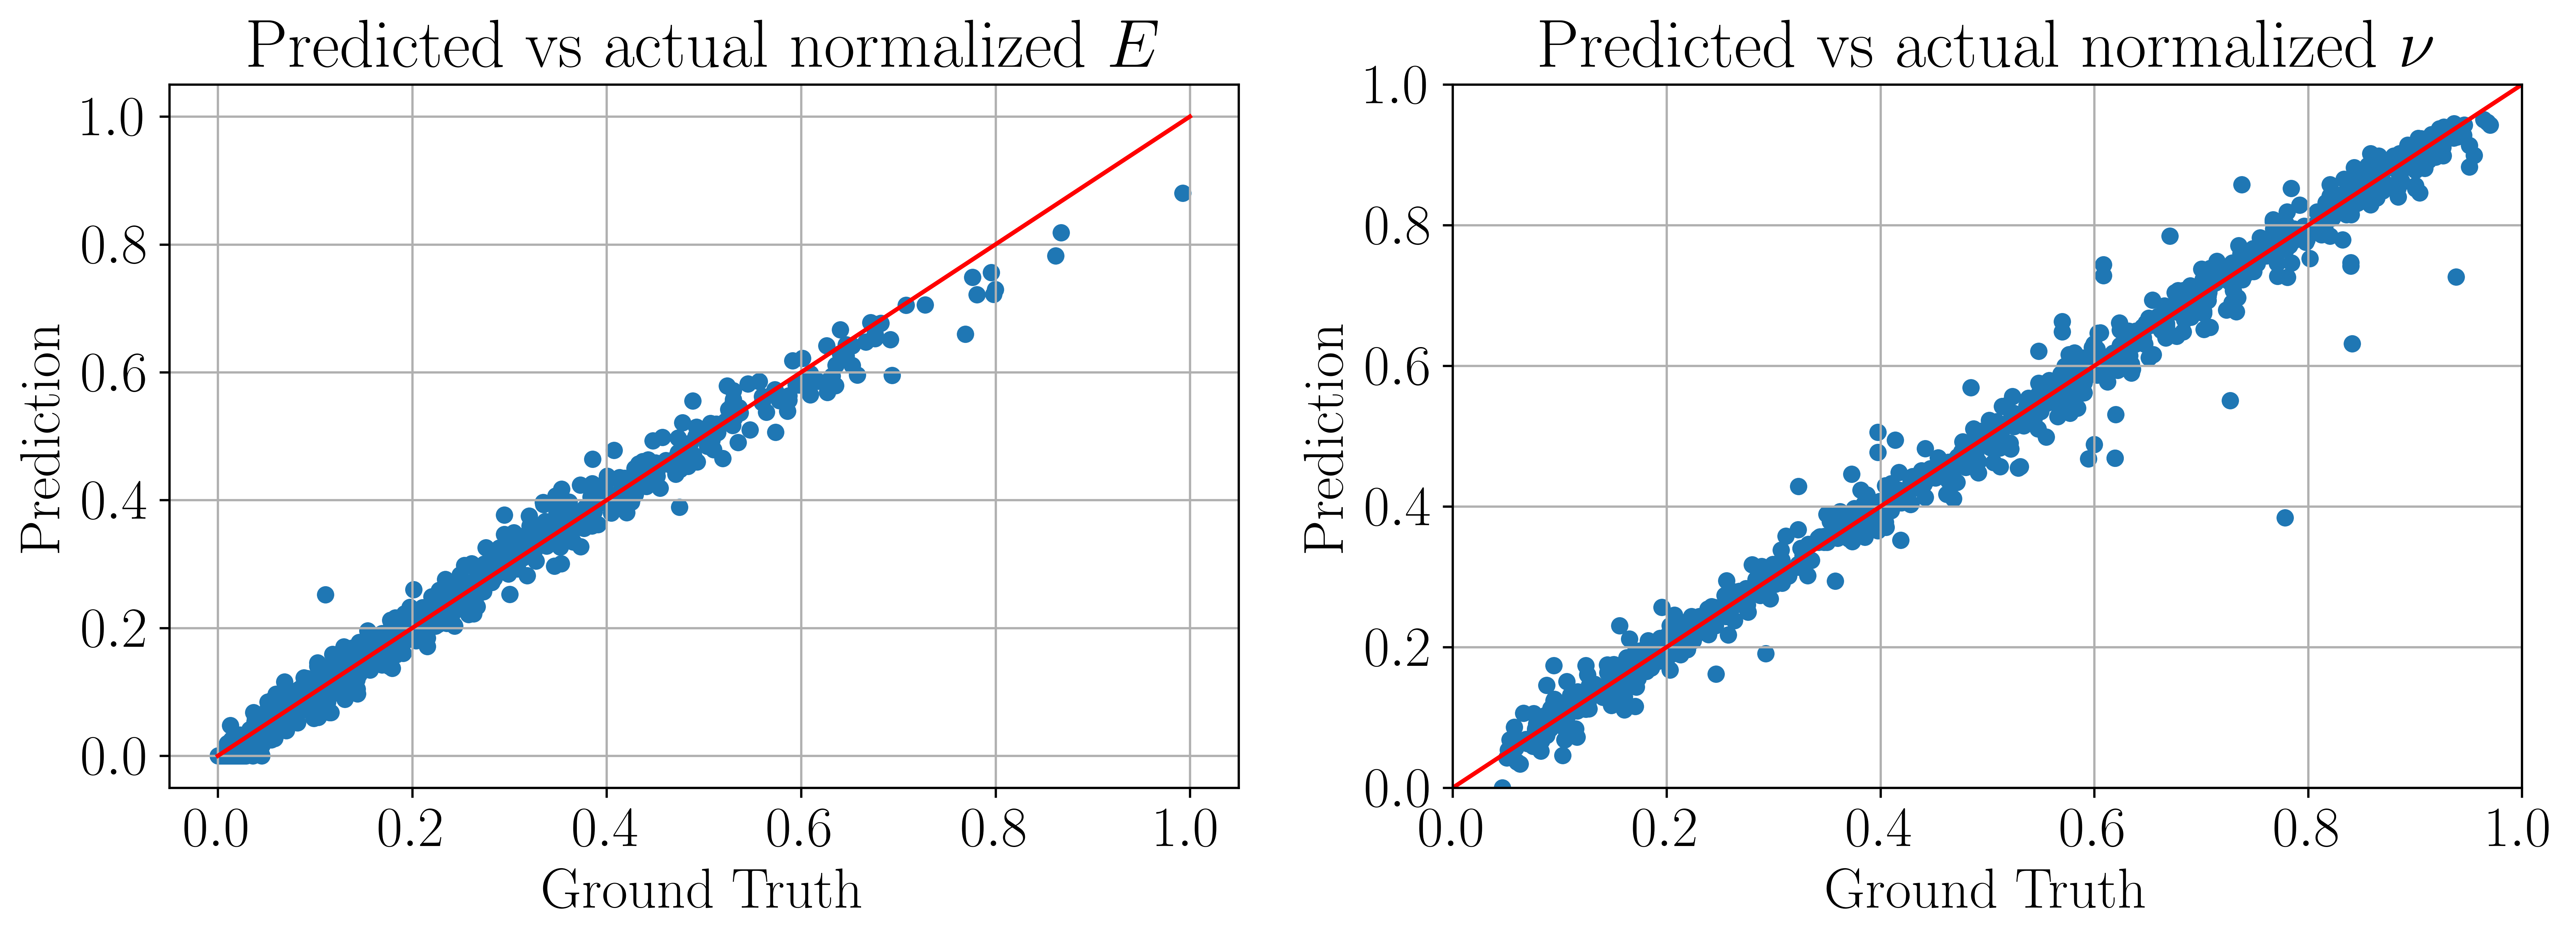

In [12]:

fig, ax = plt.subplots(1, 2, figsize=(13, 5), dpi = 600)
ax[0].scatter(E[8000:], yhat_numpy[:,0:1], linewidths=0.1)
ax[0].plot([0, 1], [0, 1], color='red')
ax[0].title.set_text('Predicted  vs actual normalized $E$')
ax[0].set_xlabel('Ground Truth')
ax[0].set_ylabel('Prediction')
ax[0].grid('on')

ax[1].scatter(nu[8000:], yhat_numpy[:,1:2], linewidths=0.1)
ax[1].plot([0, 1], [0, 1], color='red')
ax[1].title.set_text(r'Predicted vs actual normalized $\nu$')
ax[1].set_xlabel(' Ground Truth')
ax[1].set_ylabel('Prediction')
ax[1].grid('on')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"    